# ПОСТРОЕНИЕ МОДЕЛИ ДЛЯ ПРОГНОЗИРОВАНИЯ УХОДА КЛИЕНТОВ ТЕЛЕКОМ КОМПАНИИ

## ОТЧЕТ ПО ПРОЕКТУ 

### Аннотация

Удержание клиентов является одним из приоритетных направлений бизнеса. Как правило, сохранение клиенткой базы экономически выгоднее, чем привлечение новых клиентов.

**Отток клиентов** — одна из наиболее важных метрик, которые оцениваются бизнесом. Этот показатель показывает реальную картину потери клиентов и, соответственно, последующую потерю доходов компании. 

Прогнозирование оттока клиентов с помощью интеллектуального анализа данных и методов машинного обучение позволит нивелировать долю нелояльных клиентов и снизить отток клиенской базы. 

**Целью данного проекта** является построение качественной модели для максимально точного прогнозирования оттока клиентов оператора связи «Ниединогоразрыва.ком».

Настоящий отчет содержит этапы и результаты работ по реализации задачи классификации методами классического машинного обучения (градиентный бустинг, случайный лес и логистическая регрессия).

### Введение

**В данном проекте были реализованы следующие этапы работ:**
1. Загружены и подготовлены к анализу данные;
2. Проведен разведочный анализ данных с формированием портрета нелояльного клиента;
3. Данные подготовлены к построению моделей:
    - разделены на обучающую и тестовую выборки;
    - подготовлены признаки с помощью кодировщиков (OneHotEncoder и StandardScaler);
    - выбраны целевые метрики качества согласно потребностям компании (оператора связи);
4. Построены модели:    
    - выбраны 4 моделей ML (градиентные бустинги, случайный лес и логистическая регрессия) и осуществлен подбор гиперпараметров с помощью Optuna;
    - определена и протестирована лучшая модель.
5. Сделаны выводы по итогам проекта. 

**Общие блоки работ** отражены на рисунке:

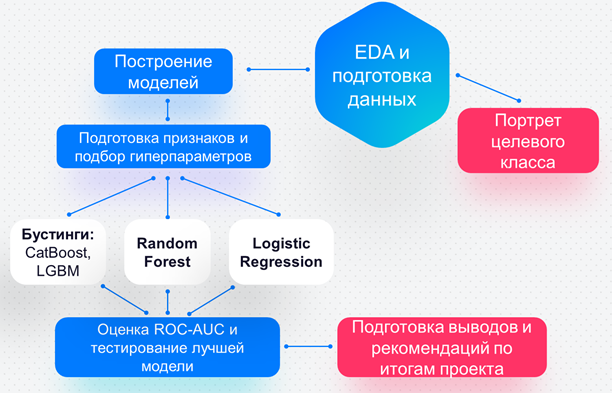

Проект был реализован **в двух ключевых направлениях:**
1. `построение модели машинного обучения`, способной прогнозировать уход клиента исходя из его потребительского поведения и персональных признаков;
2. `формирование портрета нелояльного клиента` и выявление предполагаемых причин расторжения договоров.

В рамках текущего отчета отражены результаты, полученные по данным направлениям, а также сформированы рекомендации по удержанию клиентов, склонных к оттоку.

### Данные для анализа и создание дополнительных признаков

**Данными для анализа и построения модели** являлись персональные данные о некоторых клиентах, информация об их тарифах и договорах. Выгрузка данных осуществлялась 1 февраля 2020, именно на эту дату информация являлась актуальной.

В данных присутствовала информация о следующих услугах:
- **Основные типы услуг:** 
    1. **Стационарная телефонная связь.** Возможно, подключение телефонного аппарата к нескольким линиям одновременно.
    2. **Интернет.** Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). 
- **Дополнительные услуги:**
    - Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
    - Выделенная линия технической поддержки (*TechSupport*);
    - Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
    - Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

**Исходная информация была представлена в 4-х датасетах:**
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

После объединения исходных 4-х датасетов (по столбцу `customerID`) была проведена предварительная подготовка данных к построению модели:
- заполнение пропусков на 'No' (пропуски появились при объединении таблиц и означали, что клиент не подключен к определенной услуге), 
- приведение значений признаков к нужному типу данных.

По итогу был получен **единый датафрейм**, состоящий **из 7043 объектов** и следующих признаков:

|Признак | Тип объектов| Описание признака|
| --------- | -------- | ---------|
|customer_id |object |   код клиента  |
|begin_date |datetime|  дата начала договора |
|end_date| datetime|дата окончания договора|
|type| category  |  тип договора     |
|paperless_billing| category | безбумажное выставление счетов|       
|payment_method | category |способ оплаты |       
|monthly_charges |float |ежемесячные траты |       
|total_charges| float| общие расходы на услуги |     
|gender | category | пол|       
|senior_citizen|  category |  является ли клиент пенсионером   |   
|partner | category | наличие супруга/супруги|        
|dependents  |  category   | наличие иждивенцев|     
|internet_service| category | Интернет (через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic))|  
|online_security | category |  блокировка небезопасных сайтов    |
|online_backup |category |   облачное хранилище файлов для резервного копирования данных   | 
|device_protection| category |антивирус |       
|tech_support|  category |  выделенная линия технической поддержки |    
|streaming_tv | category | стриминговое телевидение|       
|streaming_movies|category|стриминговый каталог фильмов  |      
|multiple_lines| category |  наличие подключения телефонного аппарата к нескольким линиям одновременно   |

**Созданы следующие признаки:**
- целевой признак с указанием действующего клиента (0) и бывшего (1). Количество объектов по классам: 0 - 5174 объекта (73%), 1 - 1869 объектов (27%).
- дополнительные синтетические признаки:
    - срок сотрудничества в днях на основе признаков begin_date и end_date;
    - количество услуг, используемых клиентом.

**Удалены следующие признаки:**
- begin_date и end_date с последующим их удалением, так как возможна утечка данных и исскуственное завышение качества модели;
- customer_id, так как не несет полезной информации.

### Разведочный анализ данных

**В ходе разведочного анализа:**

- выявлен `дисбаланс классов - 1:3` в пользу класса 0 (действующие клиенты). Для его устранения использовались стандартные параметры обученных моделей, например, class_weight. 
- определены `приоритетные метрики качества` для модели классификации (`roc-auc, recall и accuracy`);
- проведен `сравнительный анализ особенностей целевых классов` (группы услуг, ТОП-5 наборов услуг по действующим и бывшим клиентам и т.д.) и сформулированы `типичные характеристики бывших клиентов телеком оператора:`
    - `заключают договор ежемесячно`, а не на долгосрочный срок (1-2 года);
    - предпочитают `безбумажное выставление счета с использованием электронного чека`, как способа оплаты;
    - `реже используют дополнительные услуги`, чем лояльные клиенты;
    - отдают предпочтение `скоростному интернет-подключению (Fiber optic);`
    - среднее `количество услуг 2-5` (медиана 4 услуги);
    - `срок сотрудничества` варьируется `от 1 месяца до 2,5 лет;`
    - `средний чек` бывших клиентов больше, чем у действующих - `55-90` и 20-90 денежных ед. соответственно. Предполагаемая причина - у клиентов, которые ушли, была потребность в более скоростном интернете с подключением по Fiber optic, а так как оптоволоконное интернет-подключение можно было приобрести только с телефонией, то и средний чек был значительно больше;
    - `общие расходы` чаще всего варьируются в диапазоне `от 20 до 2500;`
    - особенности по `половозрастной структуре:`
        - клиенты трудоспособного возраста, не имеющие семьи и иждивенцев менее стабильны при выборе оператора, то есть более часто расторгают договор;
        - по половому признаку особенностей не выявлено.
- `выявлена предполагаемая причина расторжения договоров` - скорее всего, клиенты уходят из-за высокой стоимости услуг (стоимость телефонии с интернет-подключением Fiber optic обходится дороже, чем DSL в 1.5 раза);
- даны `рекомендации по вариантам удержания клиентов:`
    1. Рассмотреть создание `спец. предложения по подключению телефонии и скоростного интернета (без доп. услуг) на длительный срок по выгодной цене` - это позволит получить доход с клиента сразу и обеспечить более длительное сотрудничество с клиентом.
    2. Провести `мониторинг цен конкурентов на данный способ интернет-подключения`, возможно цена выше рынка и поэтому клиенты уходят.
    3. Рассмотреть `систему лояльности за долгосрочное сотрудничество`, например, бонусы или скидки клиенту через 3, 6 месяцев либо скидку на входе при заключении договора сразу на год. Это поможет продлить срок сотрудничества.

### Выбор и подготовка признаков для построения модели

С целью выбора признаков для обучения моделей ML проведен `корреляционный анализ с помощью phik`, который показал взаимосвязь не только количественных, но и качественных признаков.

Это позволило уменьшить количество признаков для обучения за счет удаления признаков с мультиколлинеарностью. 
Созданные нами признаки `'count_services'` и `'contract_term_days'` обладают достаточной корреляцией с целевым признаком 'target' (0.47) и позволяют исключить ряд признаков:
- 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'monthly_charges', 'list_services' (мультиколлинеарность с созданным входе анализа признаком 'count_services');
- 'total_charges' (высокая корреляция с 'contract_term_days');
- 'gender' - практически не коррелируется с прочими признаками, в том числе с целевым, а значит, не будет влиять на результат предсказания.

Таким образом, получим следующую корреляционную матрицу из 10 признаков:

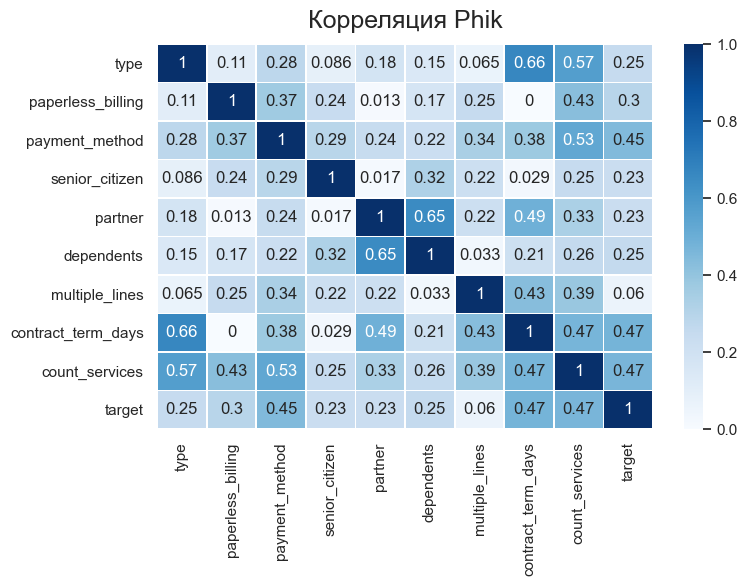

**Итоговый перечень признаков для обучения моделей:**

|Признак | Тип признака| 
| --------- | -------- | 
|type| исходный, категориальный   | 
|paperless_billing| исходный, категориальный |       
|payment_method | исходный, категориальный   |      
|senior_citizen|  исходный, категориальный  |   
|partner | исходный, категориальный  |     
|dependents  |  исходный, категориальный   | 
|multiple_lines|исходный, категориальный |
|contract_term_days|синтетический, количественный  |
|count_services|синтетический, количественный |
|target|целевой, бинарный|

В рамках **подготовки признаков для построения модели** создадим отдельные `трансформеры для логистической регрессии и случайного леса`:
- для регрессии будем использовать как кодирование категориальных признаков (`OneHotEncoder`), так и шкалирование (`StandardScaler`) для количественных признаков;
- для случайного леса шкалирование не требуется, применим только `OneHotEncoder`.

Наименования категориальных признаков использовались для catboost, для lightgbm указание признаков и кодировка не потребовались - необходимые признаки заранее приведены к типу category.

### Методы ML

#### Дополнительные требования к качеству модели от заказчика

На первоначальном этапе были определены следующие требования:
- целевая метрика **ROC-AUC** должна составить **не менее 0.85** на тестовой выборке;
- размер тестовой выборки равен 0.25;
- модель должна наиболее полно (**приоритетна метрика recall**) определять целевой класс (ушедших клиентов), так как маркетологи посчитали, что удержание текущих клиентов дешевле, чем возврат ушедших клиентов.

Данные условия были учтены при построении и оценке качества моделей.

#### Выбор методов машинного обучения и способа подбора гиперпараметров

Для достижения требуемого качества были выбраны различные **алгоритмы машинного обучения** для прогнозирования целевого класса:

|Методы ML| Основные характеристики|
| --------- | -------- | 
|Градиентные бустинги (CatBoostClassifier и LGBMClassifier)| простота реализации и хорошая обобщающая способность. В реальных задачах удается строить композиции, превосходящие по качеству базовые алгоритмы.|
|RandomForestClassifier |гибкость и высокая точность; практически не чувствителен к выбросам в данных из-за случайного семплирования (random sample); не чувствителен к масштабированию и к другим монотонным преобразованиям значений признаков. |
| LogisticRegression| простой и эффективный алгоритм, не требующий большого количества вычислительных ресурсов; не требует практически никакой настройки параметров, выводит хорошо откалиброванные предсказанные вероятности; благодаря простоте и быстроте может использоваться как базовая модель для измерения производительности более сложных алгоритмов.|


Нейронные сети не использовали, так как малое количество объектов наблюдения не позволит достичь необходимого качества модели.

Для поиска оптимальных гиперпараметров будем использовать библиотеку `Optuna`, которая является альтернативой GridSearchCV.

В завершении будет выбрана модель с наилучшими показателями целевой метрики ROC-AUC.

#### Предподготовка данных для различных моделей

- `CatBoostClassifier`

Для модели CatBoostClassifier не выполнялась предподготовка данных, только указали категориальные признаки, так как модель сама умеет их кодировать.

-  `LGBMClassifier`

Для обучения модели LGBMClassifier не требовалось даже указания категориальных признаков - модель самостоятельно находит и кодирует признаки.

- `RandomForestClassifier`

Для случайного леса с помощью трансформера применили только OneHotEncoder, так как шкалирование для данной модели не требуется - она не чувствительна к необработанным количественным переменным. 

- `LogisticRegression`

Для логистической регрессии сделали предобработку данных в виде кодирования категориальных признаков (OneHotEncoder) и шкалирование количественных признаков (StandardScaler).

#### Выбор лучшей модели

По результатам подбора гиперпараметров и кросс-валидации получили следующие результаты:

|	|CatBoostClassifier|	LGBMClassifier|	RandomForestClassifier|	LogisticRegression|
|----------|-------------|---------|----------|-----------|
|ROC-AUC	|0.92	|0.90	|0.79	|0.82|
Accuracy|	0.85|	0.76|	0.69|	0.72|
Recall|	0.80|	0.74	|0.79	|0.79|


Лучшее качество модели показал CatBoostClassifier - 0.92 (ROC-AUC), 0.85 (Accuracy) и 0.80 (Recall). 

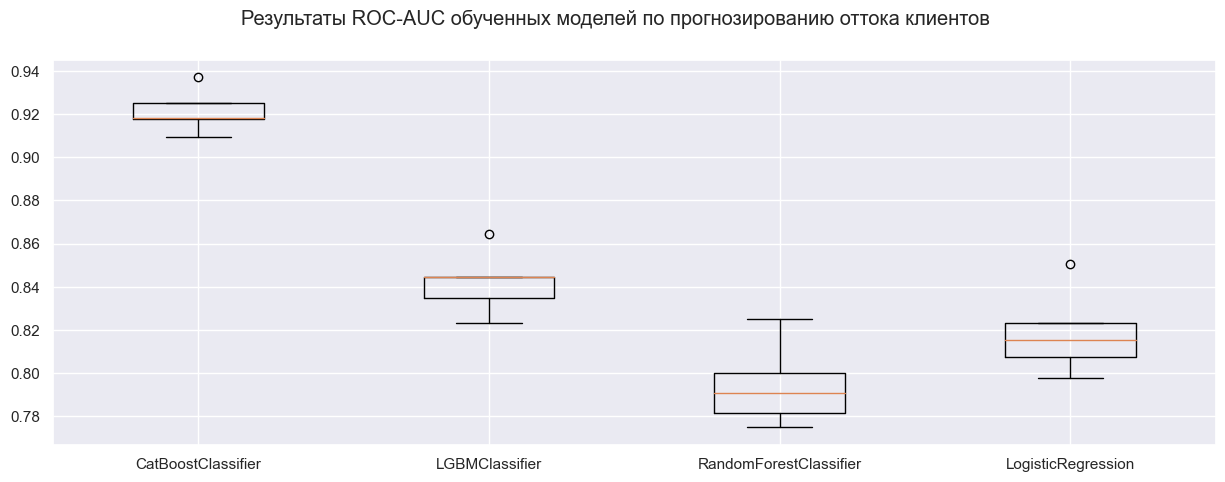

На диаграмме видим, что CatBoost показывает стабильно высокие результаты при кросс-валидации (низкое стандартное отклонение).

CatBoostClassifier признана лучшей моделью (из обученных) и использована для тестирования.

### Результаты

#### Результаты тестирования и метрики качества

По результатам тестирования получены следующие метрики:
- **ROC-AUC составляет 0.93**.

Дополнительные метрики:
- **Accuracy = 0.86**
- **Recall = 0.84**

Полученная модель соответствует требованиям по целевой метрике ROC-AUC - не менее 0.85 на тестовой выборке.

Визуализировав ROC кривую, получили следующий график:

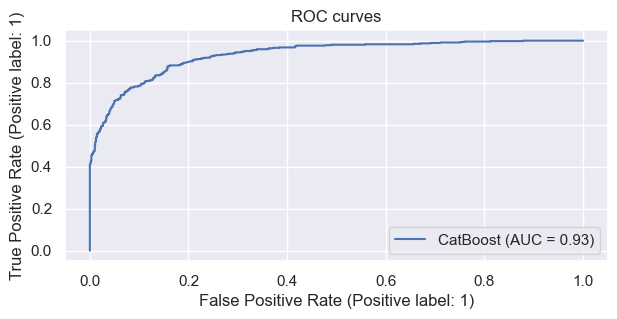

Для лучшей интерпретации полученных результатов была построена **матрица ошибок:**

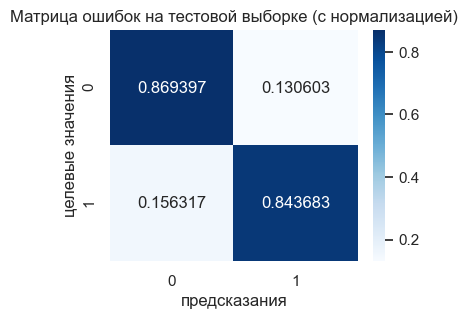

При оценке матрицы ошибок был выявлен перевес метрики Recall в пользу 0 класса. Так как по данным маркетологов удержание текущих клиентов дешевле, чем возврат ушедших клиентов, то необходимо повысить значение Recall и минимизировать ложноотрицательные ошибки (клиенты были классифицированы как лояльные, но фактически уйдут из компании).

Для этого подобрали новое пороговое значение. Визуализировали измение порога присвоения класса и подобрали оптимальный порог с учетом метрики Accuracy и Recall.

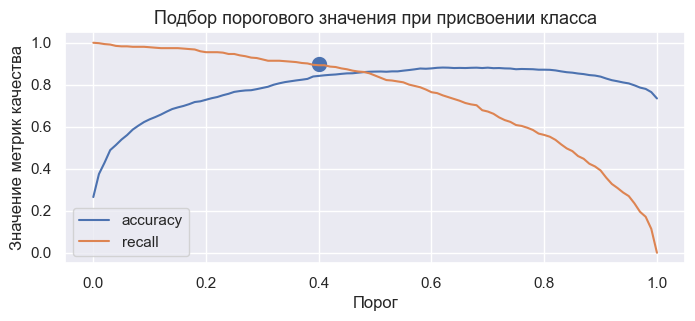

Подобрали такой порог, чтобы Accuracy не значительно снизилась, а Recall максимально увеличилась - получим 0.4. Применив новый порог, получили новую матрицу ошибок:

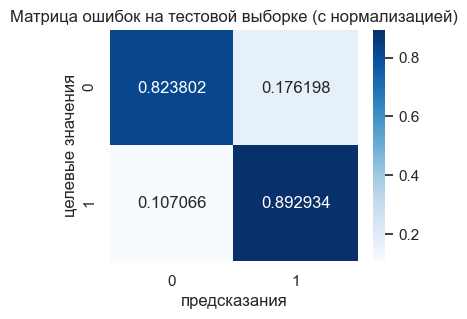

Ошибку в определении 1 класса снизили на 0.05, соответственно повысили Recall до 0.89. Полнота (Recall) 1-го класса уменьшилась на 0.05 и стала равняться 0.82. 

Таким образом, порог определения класса скорректирован в соответстствие с поставленными бизнес-целями.

#### Оценка важности признаков

Оценили график важности признаков с помощью библиотеки SHAP:

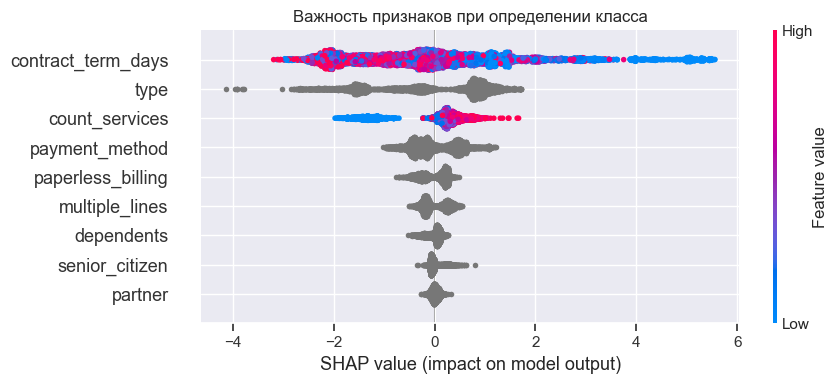

В завершении анализа итоговой модели провели оценку ТОП-3 признаков, влияющих на предсказание модели:
1. **Срок сотрудничества**. Самым весомым признаком является срок сотрудничества - чем больше срок сотрудничества, тем ниже вероятность ухода клиента. И наоборот - бывшие клиенты, в большинстве своем, сотрудничали с оператором короткое время (ранее мы выяснили, что примерный срок сотрудничества составлял 30-60 дней).
2. **Тип договора по сроку**. У лояльных клиентов срок договора более длительный.
3. **Количество услуг**. Мало склонны к уходу клиенты с минимальным количеством услуг - ранее мы выяснили, что это клиенты, использующие только телефонную связь. Тем не менее, при максимальном количестве услуг у клиентам, вероятность, что он уйдет ниже.

### Заключение
<a id='conclusion'></a>

**Оценка выполнения плана работ проекта:**

В ходе выполнения проекта были выполнены все поставленные задачи. Изменения, в части реализации плана, были внесены в следующие пункты:
- срок сотрудничества с клиентом рассчитан в днях, а не в месяцах, как было запланировано. Данная корректировка внесена для более точного расчета признака;
- не были рассчитаны средние ежемесячные затраты на клиента, так как в ходе уточнения дополнительной информации от руководителя (тимлида) были получены уточнения, что такой показатель уже находится в датасете с договорами;
- было построено 4 модели, а не 5, так как среди построенных моделей выявился явный лидер по метрикам качества (CatBoost) и время, запланированное на построение 5 модели, было потрачено на оптимизацию модели-лидера;
- для подбора гиперпараметров был использован не GridSearchCV, а библиотека Optuna, которая обладает следующими преимуществами:
     - `скорость работы`;
     - удобно формировать сетки параметров;
     - возможность задавать количество 'попыток' для подбора гиперпараметров.

Реализация закрепленных в плане задач, позволила построить модель машинного обучения, соответствующую всем заданным требования качества:
- `достигнута целевая метрика ROC-AUC` более 0.85 (результаты построенной модели на тестовой выборке равны 0.93);
- `учтен фактор более дорогого привлечения клиентов, чем удержания` - был скорректирован порог определения классов в сторону увеличения метрики `Recall` при определении целевого класса (бывших клиентов).

______
**Трудности, возникшие в процессе реализации задач проекта:**
- наблюдался некритичный дисбаланс классов, для корректировки которого была использована, встроенная в параметры моделей, балансировка;
- можно отметить необходимость ручной корректировки порога присвоения класса. Модель, показавшая наилучшую метрику качества ROC-AUC, не соответствовала ожидаемому уровню метрики Recall, поэтому была потребность в понижении порога определения 1-го класса, чтобы повысить долю выявления нелояльных клиентов с целью их удержания.

В целом при реализации проекта не возникло существенных трудностей:
- данные не содержали пропусков неизвестной природы, аномалий и дубликатов; 
- цель и основные задачи проекта были ясны.
______

**Ключевые шаги в решении задачи:**

Для решения поставленной задачи можно выделить следующие ключевые шаги (этапы):
1. Загрузка и подготовка данных к анализу;
2. Разведочный анализ данных;
3. Выбор и предподготовка признаков для обучения моделей;
4. Определение целевых метрик качества согласно типу задачи и потребностям бизнеса;
5. Подбор гиперпараметров, построение и обучение моделей;
6. Финальное тестирование и формирование выводов по итогам проекта.

______
**Перечень признаков и их предобработка для обучения модели:**

Для обучения модели были использованы следующие **признаки:**
- `исходные, категориальные`: type, paperless_billing, payment_method, senior_citizen, partner, dependents, multiple_lines;
- `синтетические, количественные`: contract_term_days (срок сотрудничества в днях), count_services (кол-во услуг клиента);
- `целевой, бинарный`: target.

Использованные **способы предобработки признаков:**
- для `catboost` передавался список категориальных признаков без дополнительной предобработки самих признаков;
- в `lightgbm` признаки передавались без дополнительной предобработки (категориальные признаки были изначально приведены к типу category), так как модель самостоятельно распознает типы признаков и кодирует их для обучения. 
- для части моделей были созданы **отдельные трансформеры**:
    - для `регрессии` использовали как кодирование категориальных признаков (`OneHotEncoder`), так и шкалирование (`StandardScaler`) для количественных признаков;
    - для `случайного леса` шкалирование не требуется, применили только `OneHotEncoder`.


______
**Итоговые параметры модели и ее качество:**

`CatBoostClassifier(random_state=RANDOM_STATE, class_weights=[1, 2.7], 
                    custom_metric= 'AUC', cat_features=ohe_features, 
                    logging_level='Silent', learning_rate=0.04936813609097174, 
                    iterations=923)`

По результатам тестирования получены следующие метрики качества:
- **ROC-AUC составляет 0.93**.
- **Accuracy = 0.86**
- **Recall = 0.84**

### Планы по дальнейшей работе над проектом

**В ходе дальнейшей работы над проектов стоит реализовать следующие задачи:**

- `кластеризация`, чтобы разделить клиентов не только на действующих и бывших, но и провести сегментацию внутри этих групп. Это позволит еще глубже изучить `поведенческие особенности клиентских кластеров` и разработать для них более `персонифицированные предложения` для удержания.
- `анализ бюджета маркетинга`. Запросить у маркетологов бюджет на удержание одного клиента и плановый бюджет на месяц/год. Это позволит `настроить пороговое значение модели` более точно - сократить либо увеличить количество выявленных нелояльных клиентов. Либо увеличить точность (`precision`), то есть находить только тех клиентов, которые с большей вероятностью уйдут либо увеличить полноту (`recall`), чтобы выявить как можно больше нелояльных клиентов, если бюджет будет достаточным.